# Demo - Uncertain GP - MCMC

In [59]:
import sys
from pyprojroot import here
root = here(project_files=[".here"])
sys.path.append(str(here()))

# Jax settings
import jax
import jax.numpy as np
import objax
import numpyro
import numpyro.distributions as dist

# Gaussian process settings
from jaxkern.data.regression import simple, near_square_wave
from jaxkern.gp.exact import ExactGP
from jaxkern.kernels.stationary import RBF, RationalQuadratic
from jaxkern.gp.mean import LinearMean, ZeroMean
from jaxkern.gp.losses import negative_log_likelihood
from jaxkern.gp.optimize import optimize_model
from jaxkern.gp.utils import confidence_intervals
from jaxkern.gp.uncertain.taylor import TaylorFirstOrder, TaylorSecondOrder
from jaxkern.gp.uncertain.mcmc import MCMCTransform

import numpy as onp

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [60]:
# X, y, Xtest, ytest = simple(30, 400, 0.0, 0.05)
ntrain = 60
ntest = 1_000
input_cov = 0.2

output_cov = 0.2
X, y, Xtest, ytest = near_square_wave(ntrain, ntest, input_cov, output_cov)

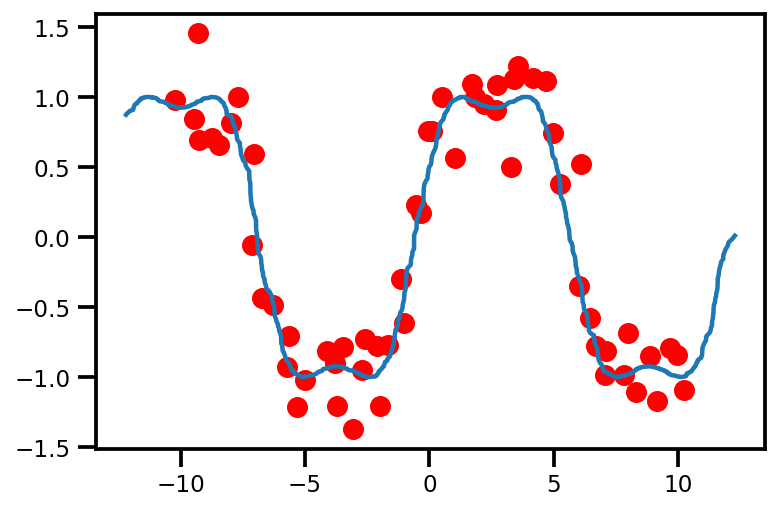

In [61]:
plt.scatter(X, y, color='red')
plt.plot(Xtest, ytest)

## Model

In [62]:
# initialize kernel
# kernel = RBF(length_scale=0.01, variance=1.0)
kernel = RationalQuadratic()

# initialize mean function
# mean = LinearMean(input_dim=1, output_dim=1)
mean = ZeroMean()

# initialize function
gp_model = ExactGP(mean=mean, kernel=kernel)

# inspect variables
for ikey, val in gp_model.vars().items():
    print(ikey, val.value)

(ExactGP).kernel(RationalQuadratic).variance [1.]
(ExactGP).kernel(RationalQuadratic).length_scale [1.]
(ExactGP).kernel(RationalQuadratic).alpha [1.]
(ExactGP).noise [0.1]


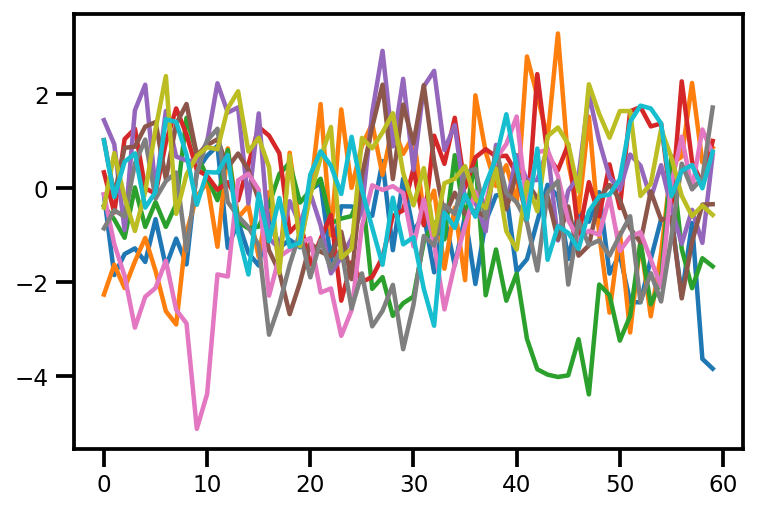

In [63]:
# generate random samples
model_dist = gp_model.forward(X)

seed = jax.random.PRNGKey(123)
y_samples = model_dist.sample((10,), seed=seed)

# plot
plt.plot(y_samples.T);

RationalQuadratic### Training

In [64]:
loss_f = jax.partial(negative_log_likelihood, gp_model)
jitted = True
n_epochs = 1_000
lr = 0.01
model, losses = optimize_model(
    model=gp_model,
    loss_f=loss_f,
    X=X, y=y,
    lr=lr,
    opt=objax.optimizer.Adam,
    n_epochs=n_epochs,
    jitted=jitted
)

100%|██████████| 1000/1000 [00:04<00:00, 226.36it/s]


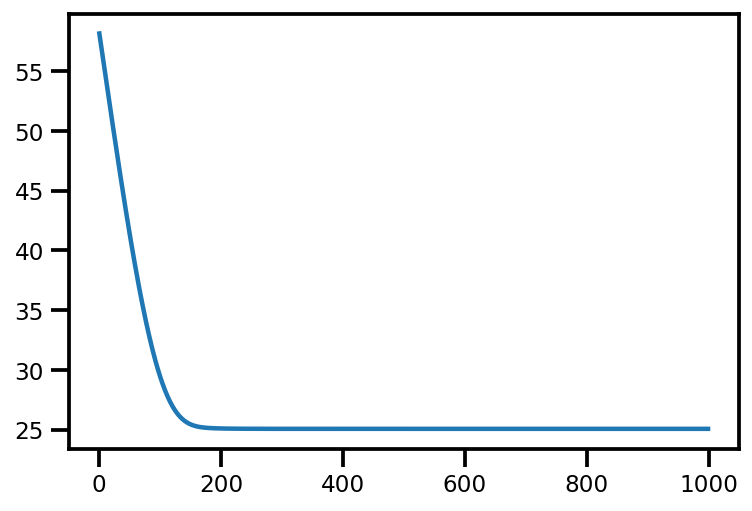

In [65]:
plt.plot(losses)

In [66]:
for ikey, val in model.vars().items():
    print(ikey, val.value, jax.nn.softplus(val.value), type(val.value), val.value.shape)

(ExactGP).kernel(RationalQuadratic).variance [1.] [1.3132617] <class 'jax.interpreters.xla.DeviceArray'> (1,)
(ExactGP).kernel(RationalQuadratic).length_scale [2.3997147] [2.4865746] <class 'jax.interpreters.xla.DeviceArray'> (1,)
(ExactGP).kernel(RationalQuadratic).alpha [0.69492704] [1.0997993] <class 'jax.interpreters.xla.DeviceArray'> (1,)
(ExactGP).noise [-1.2106729] [0.2608221] <class 'jax.interpreters.xla.DeviceArray'> (1,)


In [67]:
model.cache_factorizations(X, y)

mu, cov = model.predict_f(Xtest)
y_var = np.diagonal(cov)
lb, ub = confidence_intervals(mu, y_var, 96)

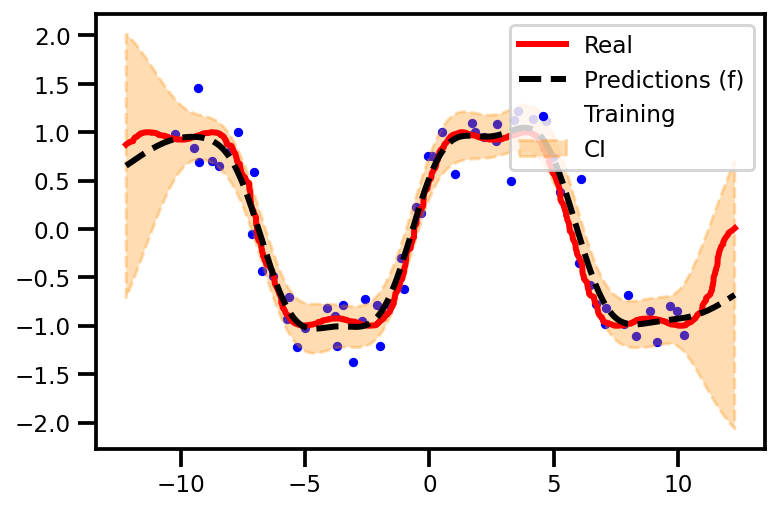

In [68]:
# plot
plt.figure()
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu, linestyle="--", label='Predictions (f)', color='black', linewidth=3)
plt.fill_between(Xtest.squeeze(), lb, ub, linestyle="--", label='CI', color='darkorange', alpha=0.3)

plt.legend()

In [69]:
mu, cov = model.predict_y(Xtest)
y_var = np.diagonal(cov)
lb, ub = confidence_intervals(mu, y_var, 96)

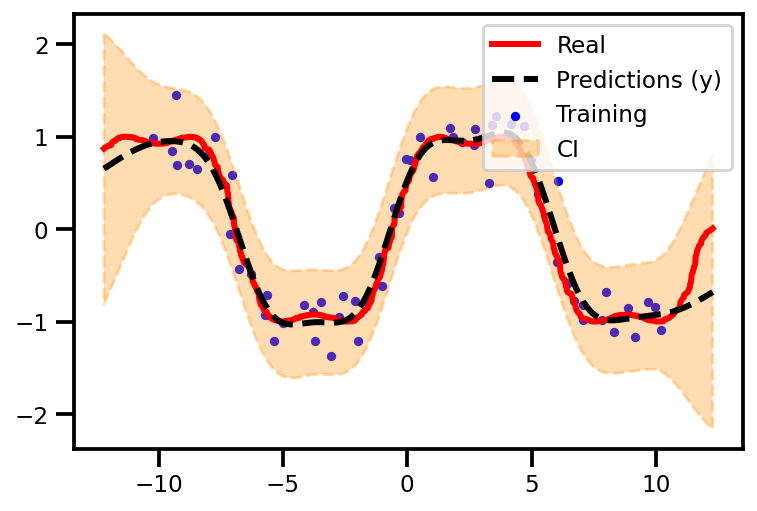

In [70]:
plt.figure()
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu, linestyle="--", label='Predictions (y)', color='black', linewidth=3)
plt.fill_between(Xtest.squeeze(), lb, ub, linestyle="--", label='CI', color='darkorange', alpha=0.3)

plt.legend()

## MCMC

In [76]:
mc_transform = MCMCTransform(model, jitted=True)

In [77]:
Xtest_cov = np.tile(np.diag(np.array([input_cov])), (ntest, 1, 1))
mean_f, var_f = mc_transform.forward(Xtest, Xtest_cov, 1_000)

(1000, 1) (1000, 1, 1) (1000, 1000, 1)


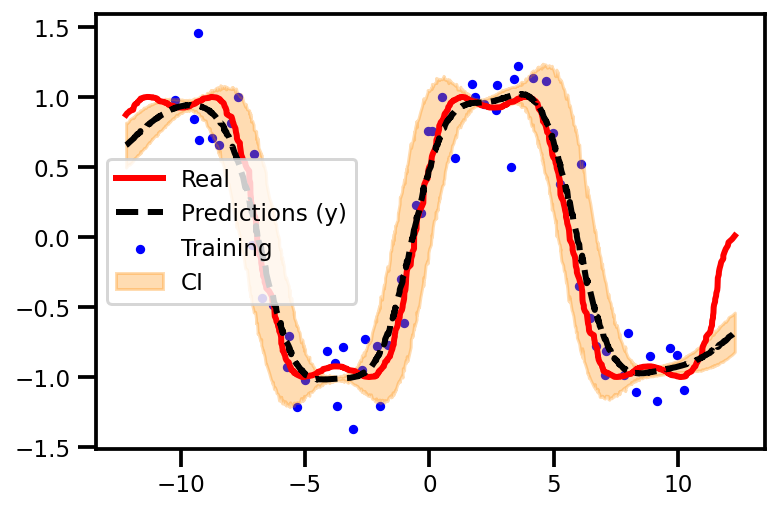

In [73]:
lb, ub = confidence_intervals(mean_f, var_f, 96)
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mean_f, linestyle="--", label='Predictions (y)', color='black', linewidth=3)
plt.fill_between(Xtest.squeeze(), lb, ub, label='CI', color='darkorange', alpha=0.3)

plt.legend()

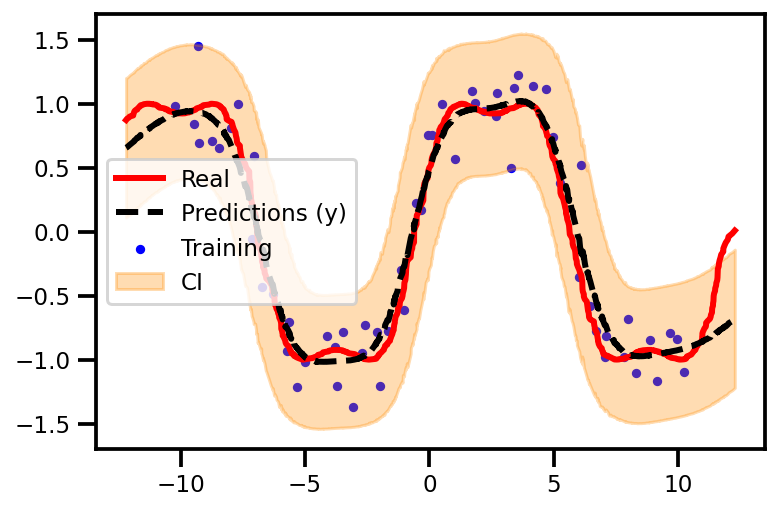

In [74]:
sigma = jax.nn.softplus(model.noise.value)

lb, ub = confidence_intervals(mean_f, var_f  + sigma ** 2, 96)
plt.figure()
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mean_f, linestyle="--", label='Predictions (y)', color='black', linewidth=3)
plt.fill_between(
    Xtest.squeeze(), 
    lb, ub, 
    label='CI', color='darkorange', alpha=0.3)

plt.legend()

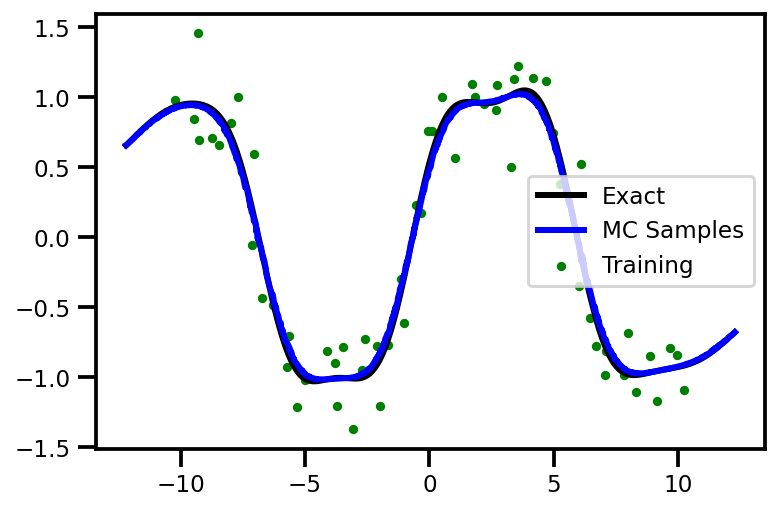

In [75]:
plt.figure()
plt.scatter(X, y, label='Training', color='green', s=10)
# plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu, linestyle="-", label='Exact', color='black', linewidth=3)
plt.plot(Xtest, mean_f, linestyle="-", label='MC Samples', color='blue', linewidth=3)
plt.legend()